In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));
push!(LOAD_PATH, "../src");

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

In [3]:
#nbx
using BenchmarkTools;
using Colors, Plots;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using GridSlam
using Geometry
using MyUtils

In [76]:
include("src/load_data.jl")

Loading `../data/data_4.jld2` ...

	_segs 	Vector{Segment}
	_boxes 	Vector{Segment}
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Control}
	_T 	Int64


## Plotting

In [38]:
function Plots.plot!(p::Pose; r=0.5, args...)
    plot!([p.x, p.x + r*unit_vec(p.hd)]; args...)
end

function Plots.plot!(ps::Vector{Pose}, cs::Vector{RGBA{Float64}}; r=0.5, args...)
    for (p,c) in zip(ps,cs)
        plot!([p.x, p.x + r*unit_vec(p.hd)];c=c, args...)
    end
end

function Plots.plot!(ps::Vector{Pose}; r=0.5, args...)
    myplot=nothing
    for p in ps
        myplot = plot!([p.x, p.x + r*unit_vec(p.hd)]; args...)
    end
    return myplot
end

## Distributions we need

In [39]:
#nbx
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src")
using GenDistributionZoo: ProductDistribution, diagnormal

mvuniform = ProductDistribution(uniform);
mvuniform(zeros(5), ones(5))

5-element Vector{Float64}:
 0.07870940996139919
 0.45769040583666243
 0.1363477875540553
 0.9758808166706537
 0.9894293699023284

## Model parts

### Pose-prior model

In [56]:
#nbx --fname="src/pose_prior_model.jl"
_bb = bounding_box(_segs);

"""
    p = pose_prior_model(p=nothing, x_noise=0.25, hd_noise=45.)

Model depends on global variable `_segs`.
"""
@gen function pose_prior_model(p=nothing, x_noise=0.25, hd_noise=45/360*2π, bb=_bb)
    if p == nothing
        x  ~ mvuniform(bb...)
        hd ~ uniform(0,2π)
    else
        x  ~ diagnormal(p.x, [x_noise, x_noise])
        hd ~ normal(p.hd, hd_noise)
    end
    return Pose(x, hd)
end;

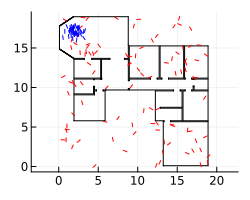

In [61]:
ps = [pose_prior_model(nothing) for t=1:100]
qs = [pose_prior_model(_ps[1], .5, 15/360*2π) for t=1:50]

# ----------------------
plot(size=(250,200), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
plot!(ps,c=:red)
plot!(qs,c=:blue)

### Control Prior

In [73]:
#nbx
@gen function control_prior_model(dx_noise=0.25, dhd_noise=45/360*2π)
    dx  ~ diagnormal([0;0], [dx_noise, dx_noise])
    dhd ~ normal(0, dhd_noise)
    return Control(dx, dhd)
end;

In [74]:
control_prior_model(0.10, 45/360*2π)

Control([-0.01674686568069579, -0.0702131098356022], -0.7621260696209471)

### Motion model

In [75]:
#nbx --fname="src/motion_model.jl"
"""
    p′ = motion_model(p, u, x_noise=0.25, hd_noise=22.5)

Sample a new pose `p′` given the previous pose `p`, 
some control data `u = Control(dx, dhd)`, and noise levels
`x_noise` and `hd_noise` (in degrees).
"""
@gen function motion_model(p, u, x_noise=0.25, hd_noise=45/360*2π)
    dx, dhd = u.dx, u.dhd
    x   ~ diagnormal(p.x  + dx , [x_noise, x_noise])
    hd  ~ normal(p.hd + dhd, hd_noise)
    return p = Pose(x, hd)
end;

### Sensor model

In [77]:
include("src/sensor.jl")

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing], var"##sensor_model_cu#378", Bool[0, 0, 0, 0], false)